In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import pandas as pd
from modules.representation_schemes import enc1d_features, get_PTR_features
from modules.function import get_metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import json
import pickle

In [10]:
phases_file = 'Files_from_GTDL_paper/gao_data.txt'
[x0,dataY]=pickle.load(open(phases_file, 'rb'))
comps = [y.split(' ')[1] for y in x0]
y = np.array(dataY)


Check number of PCA components required

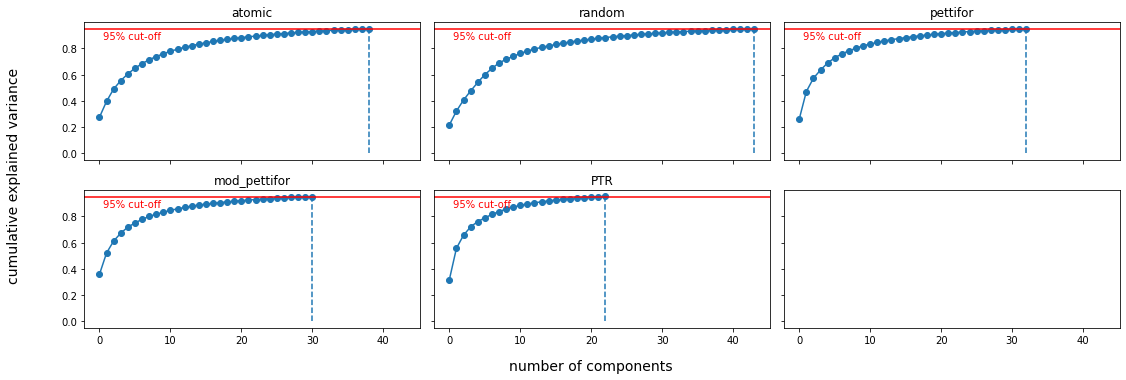

In [11]:
methods = ['atomic','random','pettifor','mod_pettifor','PTR']
component_dict = {}
fig, ax  = plt.subplots(2,3, sharey=True, sharex = True, figsize = (15,5))
ax = ax.ravel()
for i, method in enumerate(methods):
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    pca = PCA()
    features = pca.fit_transform(extracted)
    ind = np.argmax(np.cumsum(pca.explained_variance_ratio_)>0.95)
    ax[i].plot(np.cumsum(pca.explained_variance_ratio_)[:ind+1],marker = 'o')
    ax[i].vlines(ind,0,np.cumsum(pca.explained_variance_ratio_)[ind],linestyles='dashed')
    ax[i].axhline(y=0.95, color='r', linestyle='-')
    ax[i].text(0.5, 0.87, '95% cut-off', color = 'red', fontsize=10)
    ax[i].set_title(method,y=1)
    component_dict[method] = ind
fig.text(0.5, -0.04, 'number of components', ha='center', fontsize=14)
fig.text(-0.04, 0.5, 'cumulative explained variance', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()




Random Forest classifier

In [50]:
methods = ['atomic','random','pettifor','mod_pettifor','PTR']
method_dict = {}
mean_score_list = []
std_score_list = []
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    kfold = StratifiedKFold(n_splits=10, random_state=0,shuffle=True).split(features,y)#dataX
    randomforest = RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=500)
    score=[]
    fold_report = {}
    for k, (train, test) in enumerate(kfold):
        #print('\n\n 5-fold cross-validation: No.'+str(k+1))
        randomforest.fit(features[train], y[train])
        yte_pred=randomforest.predict(features[test])
        report = metrics.classification_report(y[test], yte_pred,output_dict=True)
        fold_micro_avg = report['weighted avg'].values()
        score.append(fold_micro_avg)
        fold_report['Fold_{}'.format(k)] = report



        #score.append(metrics.classification_report(y[test], yte_pred)) 
    method_dict[method] = fold_report
    score = pd.DataFrame(score,columns=['Precision','Recall','F1 Score','Support'])
    mean_score_list.append(score.mean().values)
    std_score_list.append(score.std().values)
    #print(score.mean(), score.std())

atomic
random
pettifor
mod_pettifor
PTR


Text(0.5, 0.98, '10-fold CV on HEA phases dataset')

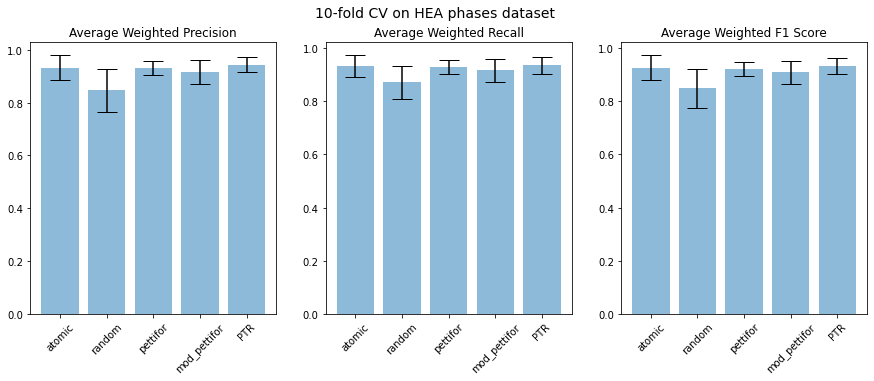

In [70]:
keys = ['Precision','Recall','F1 Score']
mean_score_list = np.array(mean_score_list)
std_score_list = np.array(std_score_list)
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax = ax.ravel()
for i,k in enumerate(keys):
    ax[i].bar(methods, mean_score_list[:,i], yerr = std_score_list[:,i],align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[i].set_title('Average Weighted {}'.format(k))
    ax[i].set_xticklabels(methods, rotation=45)
fig.suptitle('10-fold CV on HEA phases dataset', fontsize = 14)

In [49]:
with open('results/phase_prediction_cv.json','w') as fid:
    json.dump(method_dict,fid)